In [2]:
import os
import sys
#import wget
from datetime import datetime, timedelta
import xarray as xr
from zipfile import ZipFile
import numpy as np

import matplotlib.pyplot as plt
from metpy.plots import USCOUNTIES
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Note: In addition to the packages listed above, cfgrib will also need to be installed

In [5]:
import s3fs
import boto3
import botocore
from botocore.client import Config

#### Note: This code utilizes the AWS archive of NSSL MRMS data. This archive is only available for 10/14/2020-present

In [32]:
# Select Date
year = 2023
month = 6
day = 29
# Select times (in UTC)
hours = [15, 16, 17, 18, 19, 20]

#########################
ys = f'{year}'
if month < 10:
    ms = f'0{month}'
else:
    ms = f'{month}'
if day < 10:
    ds = f'0{day}'
else:
    ds = f'{day}'
date_string = f'{ys}{ms}{ds}'

times = []
for hour in hours:
    t = hour*30
    times.append(t)
    
if year < 2020:
    print('Error: Date is outside the range available in the AWS archive')
elif year == 2020 and month < 10:
    print('Error: Date is outside the range available in the AWS archive')
elif year == 2020 and month == 10 and day < 14:
    print('Error: Date is outside the range available in the AWS archive')

Error: Date is outside the range available in the AWS archive


In [80]:
s3 = boto3.resource('s3', config=Config(signature_version=botocore.UNSIGNED,
                                        user_agent_extra='Resource'))
bucket = s3.Bucket('noaa-mrms-pds')
file_names = []
for obj in bucket.objects.filter(Prefix=f'CONUS/MergedBaseReflectivityQC_00.50/{date_string}'):
    #print(obj.key)
    file_names.append(obj.key)

In [81]:
aws = s3fs.S3FileSystem(anon=True)
file_list = []
os.system(f'mkdir {date_string}')
os.system(f'mkdir {date_string}/ncfiles')

for i in times:
    name_file = f'{ys}_{ms}_{ds}_{file_names[i][91:97]}.grib2.gz'
    aws.get(f'noaa-mrms-pds/{file_names[i]}', f'{date_string}/{name_file}')
    file_list.append(name_file)

In [82]:
for j in file_list:
    os.system(f'gunzip {date_string}/{j}')
    #os.system(f'rm -r AWS/{j}')

In [83]:
file_list_2 = []

for k in file_list:
    temp = k[:23]
    file_list_2.append(temp)

In [84]:
for m in file_list_2:
    # Open grib file using xarray
    filepath = f'{date_string}/{m}'
    ds = xr.open_dataset(filepath, engine="cfgrib")
    #ds = ds.rename(unknown='Reflectivity')
    radar_data = ds['unknown']
    radar_data.to_netcdf(path=f'{date_string}/ncfiles/{m[:17]}.nc')

ECCODES ERROR   :  Truncating time: non-zero seconds(11) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(11) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(9) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(9) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(59) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(59) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(4) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(4) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(11) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(11) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(9) ignored
ECCODES ERROR   :  Truncating time: non-zero seconds(9) ignored


In [86]:
comp = np.zeros((3500, 7000))
#comp = np.zeros((700, 1400))

for m in file_list_2:
    ds_temp = xr.open_dataset(f'{date_string}/ncfiles/{m[:17]}.nc')
    data = ds_temp.unknown.data
    
    comp = np.maximum(comp, data)
    
comp

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [88]:
# Open any file to get geographic data
ds_new = xr.open_dataset(f'{date_string}/ncfiles/{file_list_2[0][:17]}.nc')

In [89]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

custom_color = ListedColormap(["darkgreen", "green", "limegreen", "yellow", "gold", "orange", "orangered", "red", "firebrick", "blueviolet"])

In [90]:
comp_threshold = comp
comp_threshold[comp_threshold<25]=-1

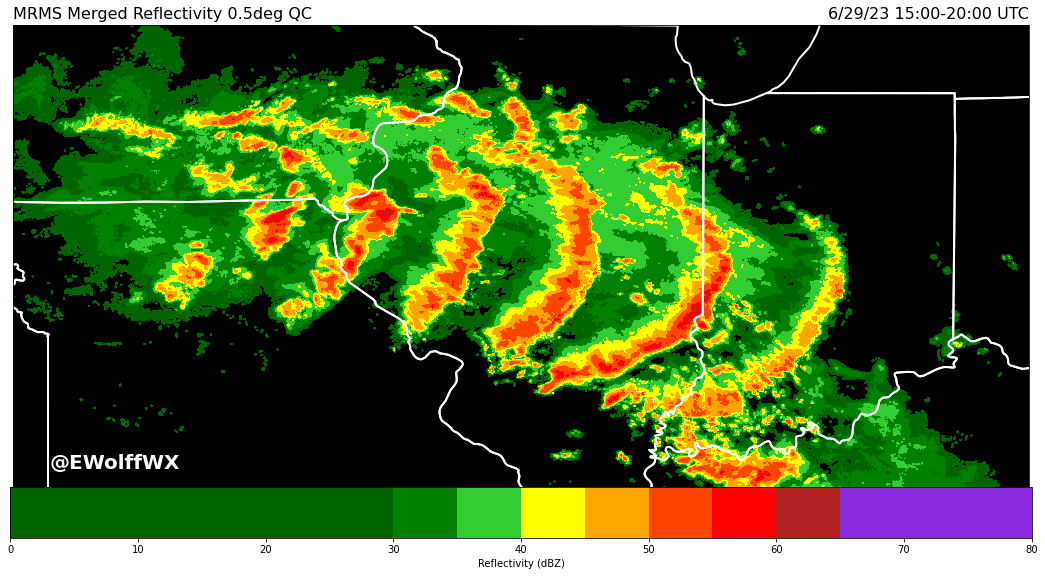

In [97]:
lats = ds_new.latitude
lons = ds_new.longitude
# Set projections
map_crs = ccrs.PlateCarree(central_longitude=0.0, globe=None)
data_crs = ccrs.PlateCarree()
# Set up figure and axis
fig = plt.figure(1, figsize=(20,10), facecolor='w')
ax = plt.subplot(1, 1, 1, projection=map_crs)
ax.set_extent([-95, -84, 37.5, 42.5], data_crs)
# Set max and min values to be displayed on map
vmin = 5
vmax = 80
levels = np.linspace(0, 80, 17)
# Plot data
im = ax.contourf(lons, lats, comp_threshold, transform=data_crs, 
                    cmap=custom_color, levels=levels, vmin=25, vmax=70)

# Add any helpful map overlays
#ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor='darkgray')
ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='white', linewidth=2)
ax.set_facecolor('black')
# Create plot title and colorbar
#plt.title('GridRad Column Max Reflectivity', loc='left')
#plt.title(f'{month}/{day}/{year} {hour}:00', loc='right')
cb = plt.colorbar(im, orientation='horizontal', pad=0, shrink=0.915)
cb.set_label('Reflectivity (dBZ)', fontsize=10)
#plt.text(-94.6, 37.7, '@EWolffWX', color='w', fontsize=20, fontweight='bold')
plt.title('MRMS Merged Reflectivity 0.5deg QC', loc='left', fontsize=16)
plt.title(f'{ms}/{ds}/{ys} {hour[0]}:00-{hours[len(hours)-1]}:00 UTC', loc='right', fontsize=16)
#plt.savefig('{date_string}_Composite.png', dpi=300, bbox_inches='tight')

plt.show()